In [1]:
import time
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from src.models import TemporalPC, MultilayertPC
from src.utils import *
torch.cuda.is_available()

True

## Some training functions

In [2]:
def val_batched_input(model, val_loader, inf_iters, inf_lr, device):
    # validation on the holdout set
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for xs in val_loader:
            batch_size, seq_len = xs.shape[:2]

            # reshape image to vector
            xs = xs.reshape((batch_size, seq_len, -1)).to(device)

            # initialize the hidden activities
            prev = model.init_hidden(batch_size).to(device)

            batch_loss = 0
            for k in range(seq_len):
                x = xs[:, k, :].clone().detach()
                model.inference(inf_iters, inf_lr, x, prev)
                energy = model.get_energy(x, prev)
                prev = model.z.clone().detach()

                # add up the loss value at each time step
                batch_loss += energy.item() / seq_len

            # add up to the loss value at each batch
            val_loss += batch_loss / batch_size
    
    return val_loss

def train_batched_input(model, optimizer, loader, val_loader, learn_iters, inf_iters, inf_lr, sparse, device):
    """Function to train tPC with batched inputs;"""
    train_losses = []
    val_losses = []
    start_time = time.time()
    for learn_iter in range(learn_iters):
        epoch_loss = 0

        # train the model
        model.train()
        for xs in loader:
            # xs = xs[0]
            batch_size, seq_len = xs.shape[:2]

            # reshape image to vector
            xs = xs.reshape((batch_size, seq_len, -1)).to(device)

            # initialize the hidden activities
            prev = model.init_hidden(batch_size).to(device)

            batch_loss = 0
            for k in range(seq_len):
                x = xs[:, k, :].clone().detach()
                optimizer.zero_grad()
                model.inference(inf_iters, inf_lr, x, prev)
                energy = model.get_energy(x, prev)

                # add sparse constraint
                if sparse is not None:
                    l1_norm = sum(torch.linalg.norm(p, 1) for p in model.parameters())
                    energy += sparse * l1_norm
                    
                energy.backward()
                optimizer.step()
                prev = model.z.clone().detach()

                # add up the loss value at each time step
                batch_loss += energy.item() / seq_len

            # add the loss in this batch
            epoch_loss += batch_loss / batch_size

        # validate the current model
        # val_loss = val_batched_input(model, val_loader, inf_iters, inf_lr, device)

        train_losses.append(epoch_loss)
        # val_losses.append(val_loss)
        if (learn_iter + 1) % 10 == 0:
            print(f'Epoch {learn_iter+1}, train loss {epoch_loss}')

    print(f'training PC complete, time: {time.time() - start_time}')
    return train_losses, val_losses

In [3]:
def _plot_PC_loss(train_losses, val_losses):
    # plotting loss for tunning; temporary
    plt.figure()
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.legend()
    # plt.savefig(fig_path + f'/{name}_losses_size{sample_size}_iters{learn_iters}')
    plt.show()

## Hyperparameters

In [4]:
train_size = 1000
val_size = 500
batch_size = 1000
h, w = 16, 16
seq_len = 50

# training hyperparameters
hidden_size = 1024
learn_lr = 1e-4
learn_iters = 200
inf_lr = 1e-2
inf_iters = 50
sparse = 1e-3

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Processing data

tensor([133848,  76787,  53787,  ...,  69754,  12020,   5597])


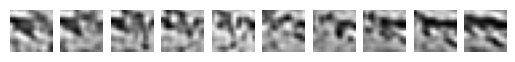

In [5]:
path = "../data/nat_data/nat_16x16x50.npy"
movie = to_torch(np.load(path), device='cpu')

# randomly shuffle the data
g_train_test = torch.Generator()
g_train_test.manual_seed(2)
idx = torch.randperm(movie.shape[0], generator=g_train_test)
movie = movie[idx]
print(idx)

# split data into train and test
train = movie[:train_size].reshape((train_size, -1, h, w))
val = movie[train_size:train_size+val_size].reshape((val_size, -1, h, w))

# visualize the data
movie0 = train[0]
n_toshow = 10
fig, ax = plt.subplots(1, n_toshow)
for i in range(n_toshow):
    ax[i].imshow(movie0[i], cmap='gray')
    ax[i].axis('off')
plt.show()

In [6]:
# make training data a dataloader
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False)
t = next(iter(train_loader))
t.shape

torch.Size([1000, 50, 16, 16])

## Train model

- Probably need a sparse constraint (nicol did it)
- Also need to train the model harder
    - with more training samples
    - and longer iterations
- But how do we evaluate the model???
    - clamp the observation layer to validation set
    - run inference
    - check the overall energy
    - this is similar to what we do in autoencoders?
    - overall it checks whether the model learns an energy landscape that describes the whole distribution of stimuli?

Epoch 10, train loss 25.98546632812501
Epoch 20, train loss 13.596587636718748
Epoch 30, train loss 9.329857734375002
Epoch 40, train loss 7.08752298828125
Epoch 50, train loss 5.666717597656248
Epoch 60, train loss 4.667811713867188
Epoch 70, train loss 3.9200285546875
Epoch 80, train loss 3.33650015625
Epoch 90, train loss 2.8676119726562503
Epoch 100, train loss 2.4827012060546876
Epoch 110, train loss 2.162123713378907
Epoch 120, train loss 1.8912528271484375
Epoch 130, train loss 1.6601602294921878
Epoch 140, train loss 1.4624580517578123
Epoch 150, train loss 1.291330075683594
Epoch 160, train loss 1.14339193359375
Epoch 170, train loss 1.0140799536132812
Epoch 180, train loss 0.9019092297363284
Epoch 190, train loss 0.8032084265136717
Epoch 200, train loss 0.7166132519531249
training PC complete, time: 610.7701215744019


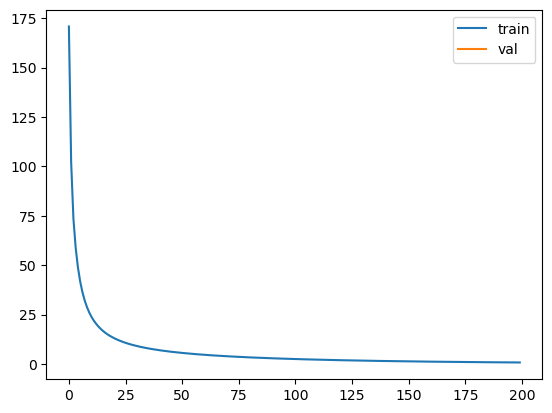

In [7]:
tPC = MultilayertPC(hidden_size, h * w).to(device)
optimizer = torch.optim.Adam(tPC.parameters(), lr=learn_lr)
                                 
train_losses, val_losses = train_batched_input(tPC, optimizer, train_loader, val_loader, learn_iters, inf_iters, inf_lr, sparse, device)
# torch.save(mpc.state_dict(), os.path.join(model_path, f'mPC_{nonlin}_size{sample_size}_seed{seed}.pt'))
_plot_PC_loss(train_losses, val_losses)

## Test the model on white noise data

Remember we have a RF for each individual neuron!

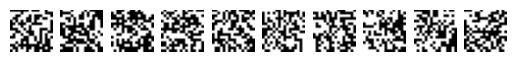

In [24]:
# testing hyperparameters
std = 2.

white_noise = (torch.rand((seq_len, h * w)) < 0.5).to(device, torch.float32)
# convert them to -1 and 1s
white_noise = std * (white_noise * 2 - 1)

fig, ax = plt.subplots(1, n_toshow)
for i in range(n_toshow):
    ax[i].imshow(to_np(white_noise[i]).reshape((h, w)), cmap='gray')
    ax[i].axis('off')
plt.show()

In [25]:
# perform inference on the white noise stimuli
inf_iters_test = 100
inf_lr_test = 1e-2

# initialize the hidden activities; batch size is 1 as we are interested in one sequence only
prev = tPC.init_hidden(1).to(device)
hidden = torch.zeros((seq_len, hidden_size))

for k in range(seq_len):
    x = white_noise[k].clone().detach()
    tPC.inference(inf_iters_test, inf_lr_test, x, prev)
    prev = tPC.get_hidden()
    hidden[k] = tPC.get_hidden()

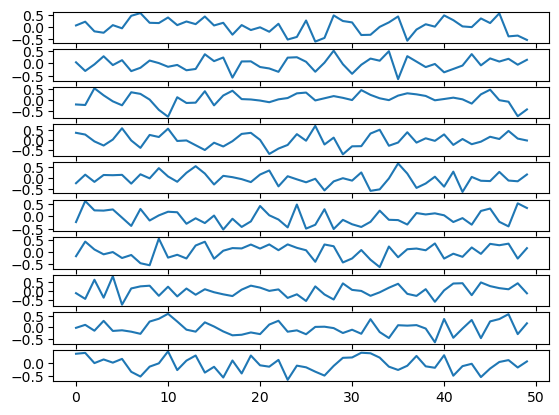

In [26]:
# plot the responses of first 10 hidden neurons
n_neurons = 10
hidden = to_np(hidden)

fig, ax = plt.subplots(n_neurons, 1)
for i in range(n_neurons):
    ax[i].plot(hidden[:, i])
plt.show()

In [27]:
# reverse correlation
def reverse_correlate(responses, tau):
    """
    Input:
        responses: neuron responses (of a single neuron) over a time course
                shape (tau, 1)
        tau: preceding time steps used for calculating the RF

    Output:
        strfs: the final spatio-temporal receptive fields, of shape (tau, h*w)
    """
    strfs = np.zeros((tau, h * w))
    for k in range(tau, seq_len):
        # get the preceding responses up to tau steps before
        preceding_res = responses[k-tau:k] # tau, 1

        # weight the stimuli with these response
        preceding_stim = to_np(white_noise)[k-tau:k] # tau, (h*w)
        weighted_preceding_stim = np.array([preceding_res[i] * preceding_stim[i] for i in range(tau)]) # tau, (h*w)
        strfs += weighted_preceding_stim

    strfs /= (seq_len - tau)
    return strfs
        

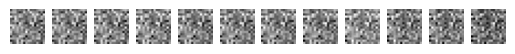

In [28]:
tau = 12
strf = reverse_correlate(hidden[:, 0], tau)
strf = strf.reshape((-1, 16, 16))

fig, ax = plt.subplots(1, tau)
for i in range(tau):
    ax[i].imshow(strf[i], cmap='gray')
    ax[i].axis('off')
plt.show()